<img src="https://global.utsa.edu/tec-partnership/images/logos/logotipo-horizontal-azul-transparente.png"  width="600">

## **Actividad 3 | Aprendizaje supervisado y no supervisado**
### **Análisis de grandes volúmenes de datos (Gpo 10)**
#### Tecnológico de Monterrey
---
*   NOMBRE: Paulina Escalante Campbell
*   MATRÍCULA: A01191962
---
### **Objetivo**

Se deberá de compartir un enlace a un archivo Jupyter Notebook en el cual, se implementen todas las etapas para el desarrollo del proyecto. Este archivo deberá de estar organizado en secciones, desde la lectura del dataset original, pasando por la etapa de construcción de la muestra a partir de las variables de caracterización definidas para tal propósito, técnicas de muestreo usadas, fase de experimentación implementada, hasta la presentación de los resultados obtenidos. Nota: en dicha carpeta compartida deberán de estar cargados los datos originales a procesar

### **1. Imports**

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum, when, split, col, lit, max, min, expr
from pyspark.sql.functions import to_date, var_samp, variance, var_pop, month, to_timestamp, dayofweek
from pyspark.sql.functions import hour, month
from pyspark.sql.types import NumericType, IntegerType, FloatType
from pyspark.sql.functions import col, round, concat_ws, desc, when, concat
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

from datetime import datetime

# Imports adicionales necesarios
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when, count as spark_count
import numpy as np
from ydata_profiling import ProfileReport

# Visualización avanzada - siguiendo metodologías de la Sesión 5
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import altair as alt

# Configurar estilos de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### **2. Selección y limpieza de los datos**

Para esta actividad final, se propone recolectar una muestra de dimensión contenida (para evitar que los tiempos de procesamiento sean altos) a partir de la base de datos que estás trabajando en tu proyecto. Para ello y tomando como base actividades previas en las cuales implementé códigos que permiten obtener particiones de la base de datos global D que cumplen con los criterios de las variables de caracterización identificadas, me permitirá construir una muestra M a partir de la unión de las instancias que se recuperan de este proceso.

In [2]:
spark = SparkSession.builder \
    .appName("Maestria_evidencia1") \
    .config("spark.driver.memory", "64g") \
    .config("spark.executor.memory", "32g") \
    .config("spark.sql.shuffle.partitions", "32") \
    .config("spark.default.parallelism", "16") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Mejores tablas
spark.sparkContext.setLogLevel("ERROR") # Quitar warnings innecesarios de Jupyter
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/22 13:01:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
####
#### La base de datos ha sido limpiada y modificada a este punto
#### 
####
file_path = "/Users/pauescalante/Documents/Maestria/Trimestre 7/BigData/big-data-act/DataModified/expanded_database_ecommerce"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Mostrar cuantos registros se tienen inicialmete para en el futuro reducir a una dimensión contenida
initial_total_count = df.count()
print(f"Número total de registros: {initial_total_count}")

[Stage 3:=================================================>    (135 + 11) / 146]

Número total de registros: 109950731


In [4]:
# Imprimiendo el esquema del Dataframe
df.printSchema()

root
 |-- event_time: date (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_time_ts: timestamp (nullable = true)
 |-- parent_category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- price_bucket: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- is_weekend: boolean (nullable = true)



In [5]:
# Mostrar el primer registros de ejemplo para visualizar las columnas
df.show(n=1,truncate=False, vertical=True)

-RECORD 0-----------------------------------------------
 event_time      | 2019-11-17                           
 event_type      | view                                 
 product_id      | 5300440                              
 category_id     | 2053013563173241677                  
 brand           | vitek                                
 price           | 17.76                                
 user_id         | 513341639                            
 user_session    | d9544029-2739-4d16-9cac-79650460d9f0 
 event_time_ts   | 2019-11-17 05:35:32                  
 parent_category | None                                 
 subcategory     | None                                 
 price_bucket    | low                                  
 day_of_week     | 1                                    
 is_weekend      | true                                 
only showing top 1 row



In [6]:
# En este punto en actividades previas se limpiaron los datos
# Pero haremos una última limpieza para verificar

#Se eliminan registros con valores nulos
df_clean = df.dropna()

#Se eliminan columnas con valores nulos
df_clean = df_clean.na.drop()

#Se eliminan registros duplicados
df_clean = df_clean.dropDuplicates()
df = df_clean

In [ ]:
### **3. Construcción de la muestra M**

Construimos una muestra M que sea representativa de la población P. Tomando como base el conocimiento adquirido en las actividadezs previas, generarás particiones Mi de M, donde cada Mi cumple con los criterios definidos por las variables de caracterización que identificamos (M será igual a la unión de todos los Mi).

In [7]:
# Calcular muestras M pre-procesada, en las actividades anteriores definimos que SRS (Simple Random Sampling) era buena opción inicial
# Ya que tenemos una poblacion muy grande (approx. 109950731, podemos usar un 0.01% de muestra y tener un número significativo de datos)
print("\n--- SRS sampling: ---")
sample_df = df.sample(fraction=0.0001)
total_count_sample = sample_df.count()
print(f"New sample size: {total_count_sample})")


--- SRS sampling: ---


[Stage 9:=======================================================> (31 + 1) / 32]

New sample size: 10956)


In [8]:
# Se añade una nueva columna que combina los valores de los atributos event_type y event_type
# Las variables de caracterización serán usadas para un multistep muestro para representar la población
from pyspark.sql.functions import concat, lit
preparedDF_a_srs = sample_df.withColumn("stratum", concat(sample_df["event_type"], lit("_"), sample_df["price_bucket"]))
preparedDF_a_srs.show(n=1,truncate=False, vertical=True)

[Stage 15:>                                                         (0 + 1) / 1]

-RECORD 0-----------------------------------------------
 event_time      | 2019-11-17                           
 event_type      | view                                 
 product_id      | 17300588                             
 category_id     | 2053013553853497655                  
 brand           | dior                                 
 price           | 154.19                               
 user_id         | 571940994                            
 user_session    | 9225e322-eb6f-4ce5-98df-e0a63c513974 
 event_time_ts   | 2019-11-17 06:22:16                  
 parent_category | None                                 
 subcategory     | None                                 
 price_bucket    | medium                               
 day_of_week     | 1                                    
 is_weekend      | true                                 
 stratum         | view_medium                          
only showing top 1 row



In [9]:
# Se calcula la cantidad de instancias por cada valor diferente de las variables event_type, price_bucket y combinada
preparedDF_a_srs.cache() # cache ya que se usa 4 veces

results = {
    "event_type": preparedDF_a_srs.groupBy("event_type").count().cache(),
    "price_bucket": preparedDF_a_srs.groupBy("price_bucket").count().cache(),
    "combined": preparedDF_a_srs.groupBy("event_type", "price_bucket").count().cache(),
    "stratum": preparedDF_a_srs.groupBy("stratum").count().cache()
}

In [10]:
# Triggering el collect en otra linea con cache ayuda con el proceso y que no sea tan lento
srs_counts_event_type = results["event_type"].collect()
srs_counts_price_bucket = results["price_bucket"].collect()
srs_counts_combined_a = results["combined"].collect()
srs_counts_combined = results["stratum"].collect()

In [11]:
# Coleccionar en pandas para usarlos en mapplotlib para visualizaciones
df_event_type = pd.DataFrame(srs_counts_event_type, columns=['event_type', 'count'])
df_price_bucket = pd.DataFrame(srs_counts_price_bucket, columns=['price_bucket', 'count'])
df_combined_a = pd.DataFrame(srs_counts_combined_a, columns=['event_type', 'price_bucket', 'count'])
df_stratum = pd.DataFrame(srs_counts_combined, columns=['stratum', 'count'])

#### **Variables de categorízación definidas en actividades previas**

EVENT_TYPE:
   - Categorías: view, cart, purchase
   - Distribución: Altamente desbalanceada (~98.5% no-purchase)
   - Implicación: Clase minoritaria requiere cuidado especial

PRICE_BUCKET:
   - Categorías: low, medium, high  
   - Distribución: Relativamente balanceada (~33% cada una)
   - Implicación: Facilita estratificación

COMBINACIÓN (STRATUM):
   - Total estratos: 9 posibles (3 x 3)
   - Distribución: Variable según intersección de categorías
   - Implicación: Necesidad de suficientes muestras por estrato

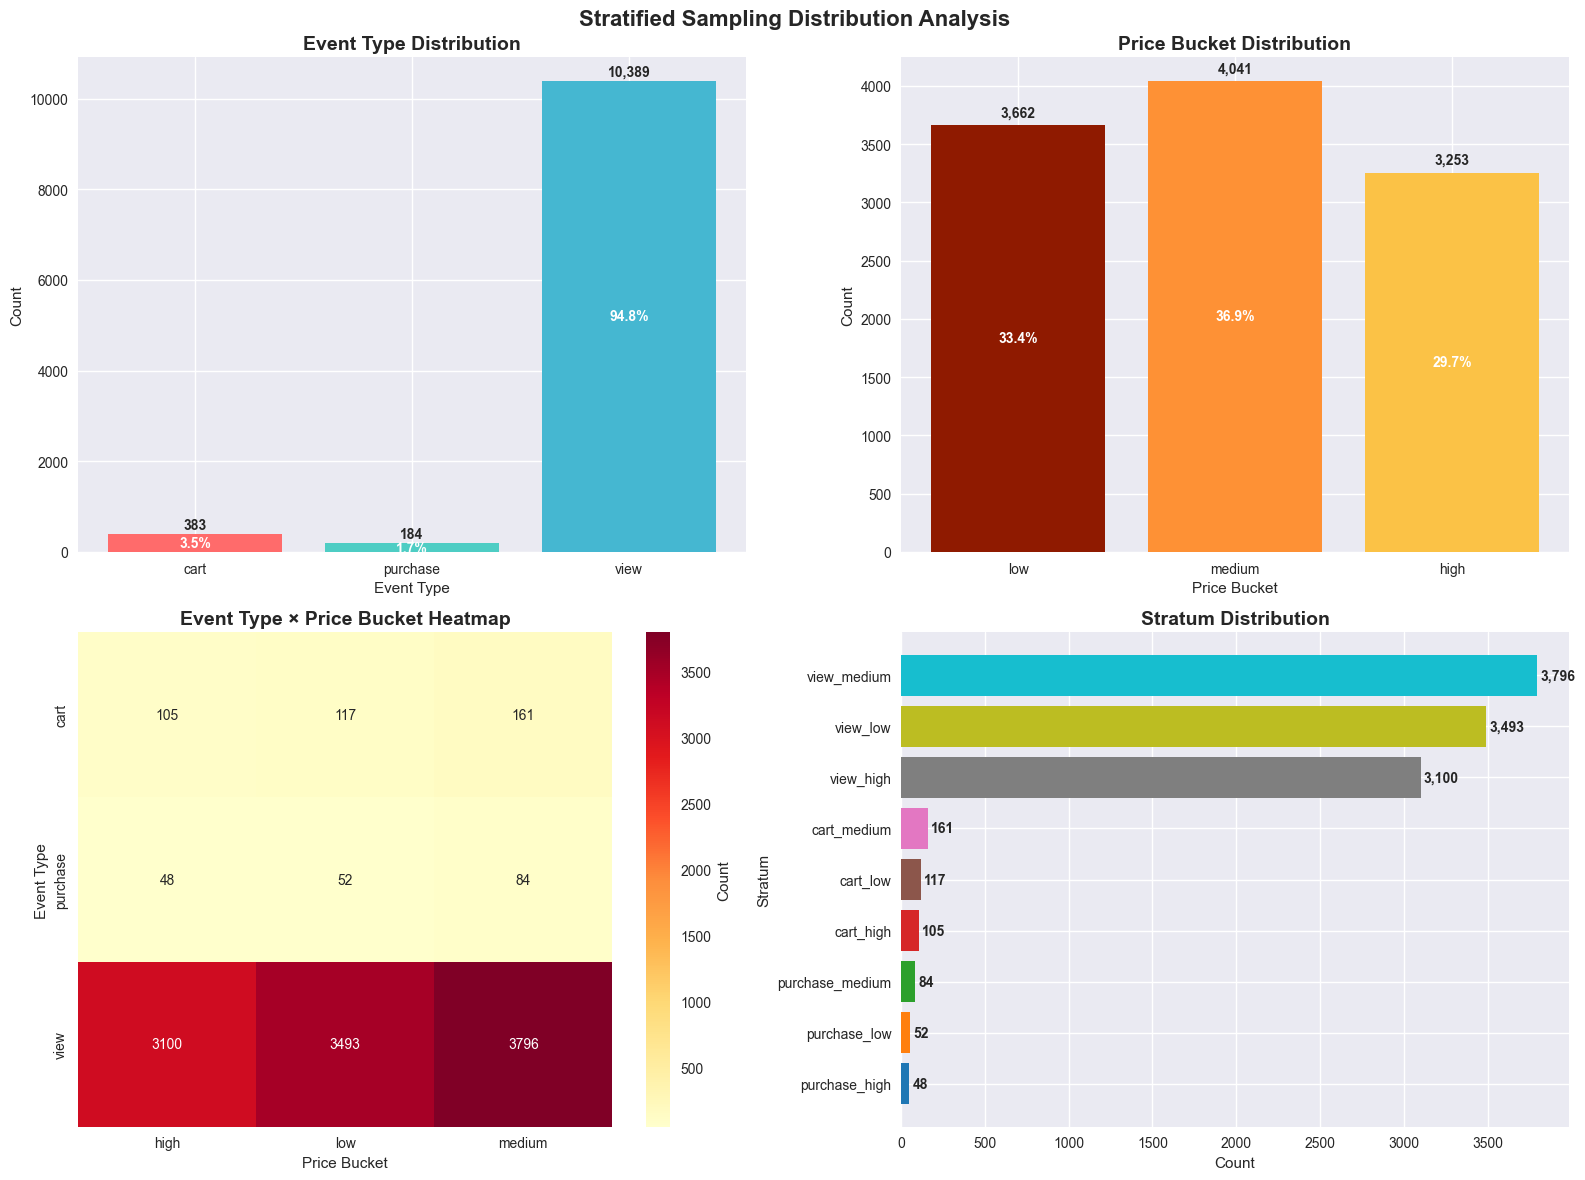

In [12]:
# Para entender un poco más la distribucion de las variables de categorízación
# Usamos visualizaciones de los valores originales y de los stratum
# 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Stratified Sampling Distribution Analysis', fontsize=16, fontweight='bold')

# Colores diferentes para la visualización
colors_event = ['#FF6B6B', '#4ECDC4', '#45B7D1']
colors_price = ['#8f1a00', '#FE9135', '#fbc246'] #warm
colors_combined = plt.cm.Set3(np.linspace(0, 1, len(df_combined_a)))
colors_stratum = plt.cm.tab10(np.linspace(0, 1, len(df_stratum)))

# Distribución de event_type
ax1 = axes[0, 0]
bars1 = ax1.bar(df_event_type['event_type'], df_event_type['count'], color=colors_event)
ax1.set_title('Event Type Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Event Type')
ax1.set_ylabel('Count')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Agregar porcentajes
total_events = df_event_type['count'].sum()
for i, bar in enumerate(bars1):
    height = bar.get_height()
    pct = (height / total_events) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{pct:.1f}%', ha='center', va='center', color='white', fontweight='bold')

# Distribución de price_bucket
ax2 = axes[0, 1]
bars2 = ax2.bar(df_price_bucket['price_bucket'], df_price_bucket['count'], color=colors_price)
ax2.set_title('Price Bucket Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Price Bucket')
ax2.set_ylabel('Count')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Agregar porcentajes
total_price = df_price_bucket['count'].sum()
for i, bar in enumerate(bars2):
    height = bar.get_height()
    pct = (height / total_price) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{pct:.1f}%', ha='center', va='center', color='white', fontweight='bold')

# Combinacion de event_type y price_bucket
ax3 = axes[1, 0]
# Create pivot table for heatmap
pivot_data = df_combined_a.pivot(index='event_type', columns='price_bucket', values='count')
sns.heatmap(pivot_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax3, 
            cbar_kws={'label': 'Count'})
ax3.set_title('Event Type × Price Bucket Heatmap', fontsize=14, fontweight='bold')
ax3.set_xlabel('Price Bucket')
ax3.set_ylabel('Event Type')

# Distribución de stratum, debe ser parecida a la combinación
ax4 = axes[1, 1]
# Sort by count for better visualization
df_stratum_sorted = df_stratum.sort_values('count', ascending=True)
bars4 = ax4.barh(df_stratum_sorted['stratum'], df_stratum_sorted['count'], color=colors_stratum)
ax4.set_title('Stratum Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Count')
ax4.set_ylabel('Stratum')
for i, bar in enumerate(bars4):
    width = bar.get_width()
    ax4.text(width + 20, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# Queremos mantender las distrubuciones originales para entender los patrones de compras
def proportional_stratified_sample(df, stratum_col, sample_fraction=0.1, seed=42):
    """
    Mantiene distribuciones originales
    
    Parameters:
    - df: PySpark DataFrame
    - stratum_col: nombre de la columna de stratum (event_type-price_bucket)
    - sample_fraction: fracción del sample (e.g., 0.1 = 10%)
    - seed: Random seed for reproducibility
    """
    
    # Get stratum counts and total count
    stratum_counts = df.groupBy(stratum_col).count().collect()
    total_count = df.count()
    
    # Create sampling fractions dictionary (same fraction for all strata to maintain proportions)
    sampling_fractions = {}
    for row in stratum_counts:
        stratum = row[stratum_col]
        sampling_fractions[stratum] = sample_fraction
    
    print("Proportional Sampling Fractions:")
    for stratum, fraction in sampling_fractions.items():
        original_count = next(row['count'] for row in stratum_counts if row[stratum_col] == stratum)
        expected_sample_size = int(original_count * fraction)
        original_pct = (original_count / total_count) * 100
        # Entender el sampling paso a paso
        print(f"  {stratum}: {fraction:.3f} (Original: {original_count:,}, Expected sample: {expected_sample_size:,}, {original_pct:.1f}%)")
    
    # Perform stratified sampling
    sampled_df = df.sampleBy(stratum_col, sampling_fractions, seed=seed)
    
    return sampled_df, sampling_fractions

In [14]:
# Parte 2 del multi-step sampling para mantener proporciones de la población original de las variables de categorízación
proportional_sample, prop_fractions = proportional_stratified_sample(preparedDF_a_srs, "stratum", sample_fraction=0.5, seed=42)

print(f"""\nExisten {proportional_sample.count()} instancias en el conjunto nuevo""")

Proportional Sampling Fractions:
  purchase_medium: 0.500 (Original: 84, Expected sample: 42, 0.8%)
  cart_low: 0.500 (Original: 117, Expected sample: 58, 1.1%)
  cart_high: 0.500 (Original: 105, Expected sample: 52, 1.0%)
  view_high: 0.500 (Original: 3,100, Expected sample: 1,550, 28.3%)
  cart_medium: 0.500 (Original: 161, Expected sample: 80, 1.5%)
  view_low: 0.500 (Original: 3,493, Expected sample: 1,746, 31.9%)
  view_medium: 0.500 (Original: 3,796, Expected sample: 1,898, 34.6%)
  purchase_low: 0.500 (Original: 52, Expected sample: 26, 0.5%)
  purchase_high: 0.500 (Original: 48, Expected sample: 24, 0.4%)

Existen 5463 instancias en el conjunto nuevo


In [15]:
# Ver un valor random
proportional_sample.show(n=1, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------
 event_time      | 2019-11-08                           
 event_type      | view                                 
 product_id      | 1004856                              
 category_id     | 2053013555631882655                  
 brand           | samsung                              
 price           | 128.41                               
 user_id         | 564856024                            
 user_session    | 0b2d24e3-7a8c-4b77-a83d-bcedf91c85c4 
 event_time_ts   | 2019-11-08 01:26:14                  
 parent_category | electronics                          
 subcategory     | smartphone                           
 price_bucket    | medium                               
 day_of_week     | 6                                    
 is_weekend      | false                                
 stratum         | view_medium                          
only showing top 1 row



In [16]:
# sample_df tiene la muestra de la población del data set original
# Ahora usamos el stratified set
sample_df = proportional_sample
total_count_sample = sample_df.count()
print(f"New sample size: {total_count_sample}")

New sample size: 5463


In [17]:
# En actividades previas se identifico que las categorías pueden ser simplificadas y normalizadas
# Valores distintos de columnas categorícas para ver si se puede normalizar o agrupar mas información 
categoricas_columnas= ['subcategory', 'parent_category', 'brand']
output = ""
for column in categoricas_columnas:
    # Cuantos valores existen
    distinct_count = sample_df.select(column).distinct().count()
    
    output += f"\nColumna: '{column}' — {distinct_count} valores distintos\n"
    output += "-" * 50 + "\n"

print(output)


Columna: 'subcategory' — 107 valores distintos
--------------------------------------------------

Columna: 'parent_category' — 14 valores distintos
--------------------------------------------------

Columna: 'brand' — 676 valores distintos
--------------------------------------------------



In [18]:
brand_counts_spark = sample_df.groupBy("brand").count().orderBy(F.desc("count")).limit(300)

# Errores de runtime de memory leak
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

brand_counts_pd = brand_counts_spark.toPandas()

# Basic stats
total_records = sample_df.count()
unique_brands = brand_counts_pd.shape[0]
print(f"Total records: {total_records:,}")
print(f"Unique brands: {unique_brands:,}")
print(f"Average records per brand: {total_records/unique_brands:.1f}")

#Top and bottom brands
print(f"\nTop 10 most frequent brands:")
top_10 = brand_counts_pd.head(10)
for idx, row in top_10.iterrows():
    percentage = (row['count'] / total_records) * 100
    print(f"  {row['brand']}: {row['count']:,} ({percentage:.2f}%)")

print(f"\nBrands with only 1 record: {len(brand_counts_pd[brand_counts_pd['count'] == 1])}")
print(f"Brands with ≤ 10 records: {len(brand_counts_pd[brand_counts_pd['count'] <= 10])}")

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Total records: 5,463
Unique brands: 300
Average records per brand: 18.2

Top 10 most frequent brands:
  None: 760 (13.91%)
  samsung: 651 (11.92%)
  apple: 535 (9.79%)
  xiaomi: 373 (6.83%)
  huawei: 107 (1.96%)
  lg: 99 (1.81%)
  lucente: 98 (1.79%)
  bosch: 90 (1.65%)
  oppo: 75 (1.37%)
  lenovo: 65 (1.19%)

Brands with only 1 record: 0
Brands with ≤ 10 records: 242


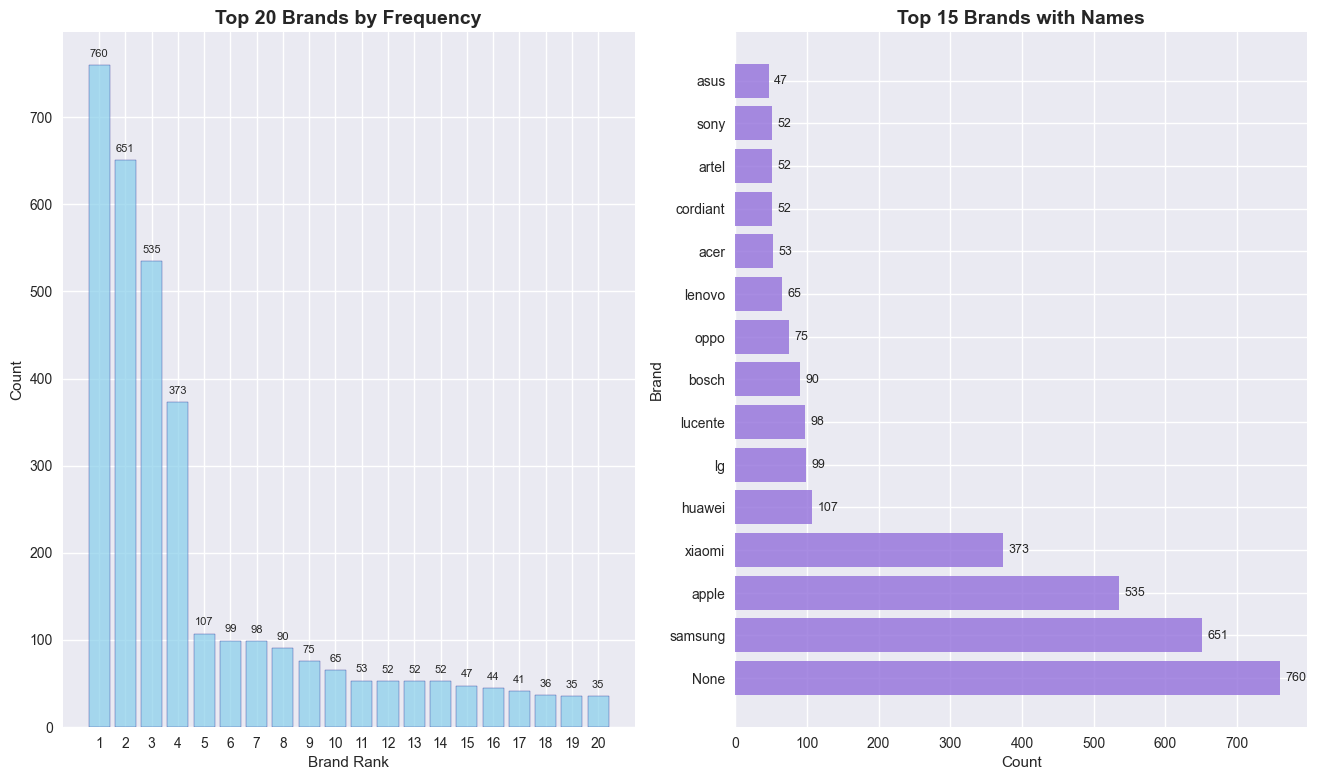

In [19]:
fig = plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
top_n = 20  # Show top 20 brands
top_brands = brand_counts_pd.head(top_n)

bars = plt.bar(range(len(top_brands)), top_brands['count'], color='skyblue', edgecolor='navy', alpha=0.7)
plt.title(f'Top {top_n} Brands by Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Brand Rank')
plt.ylabel('Count')
plt.xticks(range(len(top_brands)), [f"{i+1}" for i in range(len(top_brands))])

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + top_brands['count'].max() * 0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.subplot(2, 3, 2)
top_15_brands = brand_counts_pd.head(15)
plt.barh(range(len(top_15_brands)), top_15_brands['count'], color='mediumpurple', alpha=0.8)
plt.title('Top 15 Brands with Names', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Brand')

# Set y-tick labels to brand names (truncate if too long)
brand_labels = [brand[:20] + '...' if len(brand) > 20 else brand for brand in top_15_brands['brand']]
plt.yticks(range(len(top_15_brands)), brand_labels)

# Add value labels
for i, count in enumerate(top_15_brands['count']):
    plt.text(count + top_15_brands['count'].max() * 0.01, i, f'{count:,}', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [20]:
# Para brands, si se tienen menos de 8 registros, usamos "Others" asi reducimos variabilidad de brands
# Se selecciona 8 basado en las visualizaciones anteriores y una aproximación a un mayo rnúmero de brands representadas
min_count = 8
brands_over_min_count = (
    sample_df.groupBy("brand")
    .count()
    .filter(col("count") >= min_count)
    .select("brand")
)

# Usando esta lista hacemos un filtering
brands_list = [row["brand"] for row in brands_over_min_count.collect()]

sample_df_reduced = sample_df.withColumn(
    "brand",
    when(col("brand").isin(brands_list), col("brand")).otherwise("others")
)

print("\n--- Reducir variabilidad de brand del sample: ---")
# Cuantos valores existen en el nuevo df, reducimos de 2194 a 294
# Es una manera de normalizar el valor cetagórico de brand
distinct_count_new = sample_df_reduced.select("brand").distinct().count()
print(f"\nColumna brand: — {distinct_count_new} valores distintos\n")


--- Reducir variabilidad de brand del sample: ---

Columna brand: — 82 valores distintos



### **3. Reporte EDA de muestra**

El análisis exploratorio de datos (EDA) es una etapa fundamental en el análisis de big data, ya que permite identificar patrones relevantes, evaluar la calidad de los datos y generar resúmenes útiles para modelos predictivos posteriores. En el contexto de un dataset de e-commerce, aplicar EDA sobre una muestra representativa permite obtener una visión inicial de las tendencias de comportamiento de los usuarios, detectar posibles inconsistencias o valores atípicos, y guiar el diseño de futuras transformaciones o modelos de aprendizaje automático.

In [21]:
print("=== GENERANDO REPORTE AUTOMÁTICO DE EDA ===")
sample_df = sample_df_reduced
# Desactivar Arrow temporalmente por memory limit
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

try:
    eda_sample = sample_df.sample(fraction=0.1, seed=42).toPandas()
    
    profile = ProfileReport(eda_sample, 
                          title="EDA E-commerce Purchase Prediction",
                          explorative=True)
    
    profile.to_notebook_iframe()
finally:
    # Reactivar Arrow
    spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

=== GENERANDO REPORTE AUTOMÁTICO DE EDA ===


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/15 [00:00<?, ?it/s]
100%|██████████| 15/15 [00:02<00:00,  5.85it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### **4. Preparación del conjunto de entrenamiento y prueba**

Construcción del conjunto de entrenamiento y prueba. Para este paso se asume que M = {Mi: Mi es una partición derivada de las variables de caracterización de la población} generada en el paso anterior. Para construir el conjunto de entrenamiento y prueba, se debe de calcular el porcentaje de división a usar, de tal forma que al dividir cada Mi en un conjunto de entrenamiento (Tri) y prueba (Tsi), no se inyecten sesgos que desvíen la probabilidad de ocurrencia de los patrones en cada nueva partición. Para ello, deberás de retomar la estrategia de muestreo propuesta en el paso 4 de la Actividad 3 del módulo 4. Se debe de cuidar que Tri Ç Tsi = Æ, además de que la unión de todas las particiones es igual a M.

In [22]:
# sample_df tiene la muestra de la población del data set original
# Para separar la muestra entre sets de entrenamiento y prueba se usa un 80:20
# Es el estándar en ML y un buen balance
print("\n-- Entrenamiento/Prueba ---")
train_ratio = 0.8
test_ratio = 0.2
random_seed = 42

# Establece el número de particiones que se usarán al hacer operaciones como shuffle (por ejemplo, en joins, agregaciones o splits).
# Un número mayor puede mejorar la distribución de los datos en clústeres grandes, pero también aumentar el uso de recursos.
spark.conf.set("spark.sql.shuffle.partitions", "200") # puede alterar los resultados, empezamos con un número mayor

# Divide aleatoriamente el DataFrame `sample_df` en dos subconjuntos: uno para entrenamiento y otro para prueba.
train_data,test_data = sample_df.randomSplit([train_ratio,test_ratio], seed = random_seed)

# Imprime cuántas instancias hay en el conjunto de entrenamiento y cuántas en el conjunto de prueba.
print(f"""Existen {train_data.count()} instancias en el conjunto train, y {test_data.count()} en el conjunto test""")


-- Entrenamiento/Prueba ---
Existen 4366 instancias en el conjunto train, y 1097 en el conjunto test


In [23]:
# Verificar proporciones de los sets de training y de test con event_type, ya que esta columna tiene una distribución esperada
train_dist = train_data.groupBy("event_type").count().withColumnRenamed("count", "train_count")
test_dist = test_data.groupBy("event_type").count().withColumnRenamed("count", "test_count")
verification = train_dist.join(test_dist, "event_type")

# Las distribuciones son esperadas, con view > cart > purchase
print("\n--- Verificación de proporciones event_type: ---")
verification.show()


--- Verificación de proporciones event_type: ---
+----------+-----------+----------+
|event_type|train_count|test_count|
+----------+-----------+----------+
|  purchase|         69|        18|
|      view|       4137|      1040|
|      cart|        160|        39|
+----------+-----------+----------+



In [24]:
# Verificar proporciones de los sets de training y de test con event_type, ya que esta columna tiene una distribución normal
train_dist_2 = train_data.groupBy("price_bucket").count().withColumnRenamed("count", "train_count")
test_dist_2 = test_data.groupBy("price_bucket").count().withColumnRenamed("count", "test_count")
verification_2 = train_dist_2.join(test_dist_2, "price_bucket")

# Las distribuciones son esperadas, con un 33% aproximado en cada categoría 
print("\n--- Verificación de proporciones price_bucket: ---")
verification_2.show()


--- Verificación de proporciones price_bucket: ---
+------------+-----------+----------+
|price_bucket|train_count|test_count|
+------------+-----------+----------+
|         low|       1473|       346|
|        high|       1258|       353|
|      medium|       1635|       398|
+------------+-----------+----------+



### **5. Experimentación: modelos de aprendizaje supervisado y no supervisado**

En esta sección se deberán de documentar todos los resultados de relevancia generados a partir de la experimentación realizada. Se recomienda que se usen diferentes tipos de gráficas, tablas, etc., para mostrar los resultados obtenidos (matrices de confusión, curvas ROC, etc.). Es importante realizar una discusión de dichos resultados, para resaltar aquellos que sean los más relevantes.

En actividades pasadas se hizo un análisis y entrenamiento de aprendizaje supervisado y no supervisado, estos modelos fueron muy interesantes y crearon conclusiónes significativas, en particular el clustering de aprendizaje no supervisado. Ya que el data set que obtuvimos tiene muy pocos valores numéricos podemos obtener más insights de el segundo modelo.

#### 5.1 Aprendizaje Supervisado

Para el problema de aprendizaje supervisado haremos un análisis binario de predicción: compra o no compra

- Variable objetivo: label (1 = purchase, 0 = no purchase)
- Desafío: Dataset altamente desbalanceado (1.5% positivos)

In [25]:
# Preparar la variable objetivo "label" que identifica si es compra o no
supervised_df = train_data.withColumn("label", 
                                   when(col("event_type") == "purchase", 1.0)
                                   .otherwise(0.0))

print("Variable objetivo: label (1=purchase, 0=no purchase)")

# Seleccionar características, en este caso tenemos variables numéricas y categóricas
feature_cols = ["price", "day_of_week"]
categorical_cols = ["brand", "parent_category", "price_bucket"]

print(f"Características numéricas: {feature_cols}")
print(f"Características categóricas: {categorical_cols}")

# Revisar resultado
sample_df.select("event_time", "day_of_week").show(5)

Variable objetivo: label (1=purchase, 0=no purchase)
Características numéricas: ['price', 'day_of_week']
Características categóricas: ['brand', 'parent_category', 'price_bucket']
+----------+-----------+
|event_time|day_of_week|
+----------+-----------+
|2019-11-08|          6|
|2019-11-15|          6|
|2019-11-22|          6|
|2019-11-23|          7|
|2019-10-13|          1|
+----------+-----------+
only showing top 5 rows



In [26]:
# Preparación del dataframe para ser procesado con algoritmos de ML en PySpark
# Se usa VectorAssembler para generar una o más columnas en la cual, se "encapsulan" en un vector único
# los valores de los descriptores a usar en el proceso de aprendizaje.

# Indexar las variables categóricas (String → Numérico).
# Se crea una lista de transformadores StringIndexer, uno por cada columna categórica.
# `handleInvalid="skip"` evita errores si hay valores nulos o inesperados.
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip") 
            for col in categorical_cols]

# Ensamblar todas las variables numéricas y categóricas indexadas en una sola columna de características.
# Esto es necesario porque PySpark ML requiere una sola columna de entrada (`features`) de tipo vector.
feature_cols_final = feature_cols + [f"{col}_indexed" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols_final, outputCol="features")

# Escalar las características para normalizar los valores.
# Esto mejora el rendimiento de muchos algoritmos de ML
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [27]:
# MODELO 1: Regresión Logística
# Baseline estándar para clasificación binaria
print("\n--- Modelo 1: Regresión Logística ---")

# Se especifican las columnas de entrada (`scaledFeatures`) y etiqueta (`label`), y el número máximo de iteraciones.
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label", maxIter=10)

# Se construye un pipeline que incluye:
# 1. Indexado de columnas categóricas
# 2. Ensamblado de características
# 3. Escalado de variables
# 4. El modelo de regresión logística
lr_pipeline = Pipeline(stages=indexers + [assembler, scaler, lr])

print("Entrenando Regresión Logística...")

# Se entrena el pipeline completo con el DataFrame `supervised_df`.
lr_model = lr_pipeline.fit(supervised_df)
print("Modelo entrenado...")


--- Modelo 1: Regresión Logística ---
Entrenando Regresión Logística...
Modelo entrenado...


In [28]:
# Se Imprimen los valores de los coeficientes
lr_stage = lr_model.stages[-1]  # Última etapa es LogisticRegression
print("The coefficient of the model is :", lr_stage.coefficients)
print("The intercept of the model is :", lr_stage.intercept)

The coefficient of the model is : [0.023773252076997396,-0.02764766229035003,-0.024633173611723094,-0.2518198127278829,-0.2106553121127314]
The intercept of the model is : -3.6884836136954178


In [29]:
print("\n--- Evaluación de modelos ---")
# Preparar datos de prueba con la variable label
test_supervised = test_data.withColumn("label", 
                                    when(col("event_type") == "purchase", 1.0)
                                    .otherwise(0.0))

# Generar predicciones con el modelo de regresión logística previamente entrenado.
lr_predictions = lr_model.transform(test_supervised)

# Crear un evaluador para clasificación binaria.
# Se usará el área bajo la curva ROC (AUC) como métrica principal para evaluar qué tan bien distingue entre 0 y 1.
binary_evaluator = BinaryClassificationEvaluator(labelCol="label",rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Crear un evaluador adicional para calcular la precisión general (accuracy).
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", 
                                                      predictionCol="prediction", 
                                                      metricName="accuracy")

# Métricas para evaluar
lr_auc = binary_evaluator.evaluate(lr_predictions)
lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)

print(f"\nResultados:")
print(f"Regresión Logística - AUC: {lr_auc:.4f}, Accuracy: {lr_accuracy:.4f}")


--- Evaluación de modelos ---

Resultados:
Regresión Logística - AUC: 0.6332, Accuracy: 0.9836


In [30]:
# Matriz de confusión
print("\nMatriz de confusión:")
confusion_matrix = lr_predictions.groupBy("label", "prediction").count()
confusion_matrix.show()


Matriz de confusión:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0|   18|
|  0.0|       0.0| 1079|
+-----+----------+-----+



In [31]:
# Agregando a los resultados de la actividad pasada podemoste usar hiperparametros para mejorar el modelo
print("\n--- Búsqueda de Hiperparámetros con Grid Search ---")

# Crear el pipeline base sin el modelo final
base_pipeline = Pipeline(stages=indexers + [assembler, scaler])

# Crear un nuevo modelo de regresión logística
lr_grid = LogisticRegression(featuresCol="scaledFeatures", labelCol="label")

# Pipeline completo con el modelo
lr_pipeline_grid = Pipeline(stages=indexers + [assembler, scaler, lr_grid])

# Construir la grilla de parámetros para buscar
param_grid = ParamGridBuilder() \
    .addGrid(lr_grid.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_grid.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr_grid.maxIter, [10, 50, 100]) \
    .build()

print(f"Evaluando {len(param_grid)} combinaciones de hiperparámetros...")

# Configurar evaluador para cross-validation (usamos AUC-ROC)
cv_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# Configurar cross-validation con 3 folds
crossval = CrossValidator(
    estimator=lr_pipeline_grid,
    estimatorParamMaps=param_grid,
    evaluator=cv_evaluator,
    numFolds=3,
    seed=42
)

print("Iniciando búsqueda de hiperparámetros...")
# Entrenar con cross-validation
cv_model = crossval.fit(supervised_df)

print("Búsqueda completada. Mejor modelo seleccionado.")

# Obtener el mejor modelo
best_lr_model = cv_model.bestModel

# Obtener los mejores parámetros
best_lr_stage = best_lr_model.stages[-1]
print(f"\nMejores hiperparámetros encontrados:")
print(f"regParam: {best_lr_stage.getRegParam()}")
print(f"elasticNetParam: {best_lr_stage.getElasticNetParam()}")
print(f"maxIter: {best_lr_stage.getMaxIter()}")


--- Búsqueda de Hiperparámetros con Grid Search ---
Evaluando 27 combinaciones de hiperparámetros...
Iniciando búsqueda de hiperparámetros...
Búsqueda completada. Mejor modelo seleccionado.

Mejores hiperparámetros encontrados:
regParam: 0.01
elasticNetParam: 0.0
maxIter: 10


In [32]:
# Generar predicciones con el mejor modelo
best_predictions = best_lr_model.transform(test_supervised)


--- Evaluación Completa de Métricas ---


In [48]:
# AUC-ROC
auc_roc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# AUC-PRC (Precision-Recall Curve) - CRÍTICA para datasets desbalanceados
auc_prc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Calcular métricas principales
auc_roc = auc_roc_evaluator.evaluate(best_predictions)
auc_prc = auc_prc_evaluator.evaluate(best_predictions)
accuracy = accuracy_evaluator.evaluate(best_predictions)

print("\n--- Evaluación Completa de Métricas ---")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PRC: {auc_prc:.4f}")
print(f"Accuracy: {accuracy:.4f}")


--- Evaluación Completa de Métricas ---
AUC-ROC: 0.6232
AUC-PRC: 0.0252
Accuracy: 0.9836


In [49]:
print(f"\n--- Matriz de Confusión ---")
confusion_matrix = best_predictions.groupBy("label", "prediction").count().collect()

# Organizar resultados de la matriz de confusión
tn = tp = fn = fp = 0
for row in confusion_matrix:
    actual = row["label"]
    predicted = row["prediction"]
    count = row["count"]
    
    if actual == 0.0 and predicted == 0.0:
        tn = count  # True Negatives
    elif actual == 1.0 and predicted == 1.0:
        tp = count  # True Positives
    elif actual == 1.0 and predicted == 0.0:
        fn = count  # False Negatives
    elif actual == 0.0 and predicted == 1.0:
        fp = count  # False Positives

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


--- Matriz de Confusión ---
True Negatives (TN): 1079
False Positives (FP): 0
False Negatives (FN): 18
True Positives (TP): 0


Extrayendo curva ROC sin Arrow...


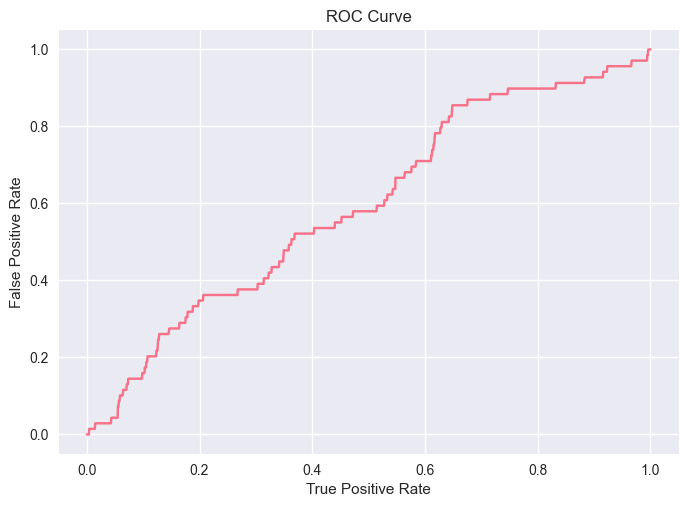

Training set areaUnderROC: 0.5950056156469125


In [50]:
# Imprimiendo la curva ROC del mejor modelo
import matplotlib.pyplot as plt
# Desactivar Arrow globalmente en Spark
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

# Alternativa para extraer datos de ROC sin toPandas()
print("Extrayendo curva ROC sin Arrow...")

trainingSummary = best_lr_stage.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

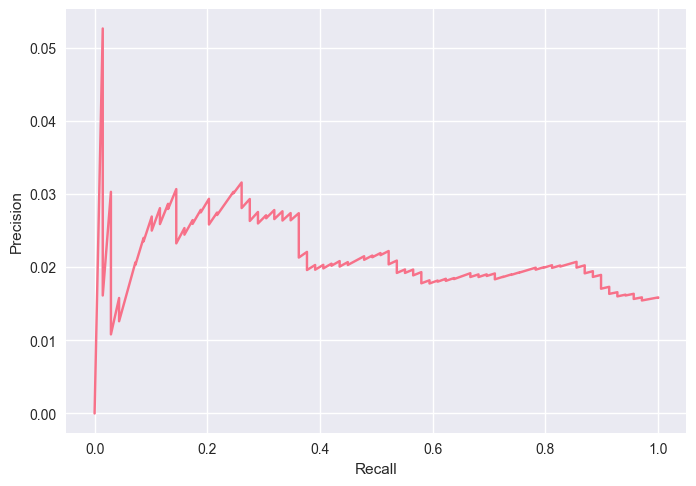

In [36]:
# Imprimiendo la curva entre Precision y Recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

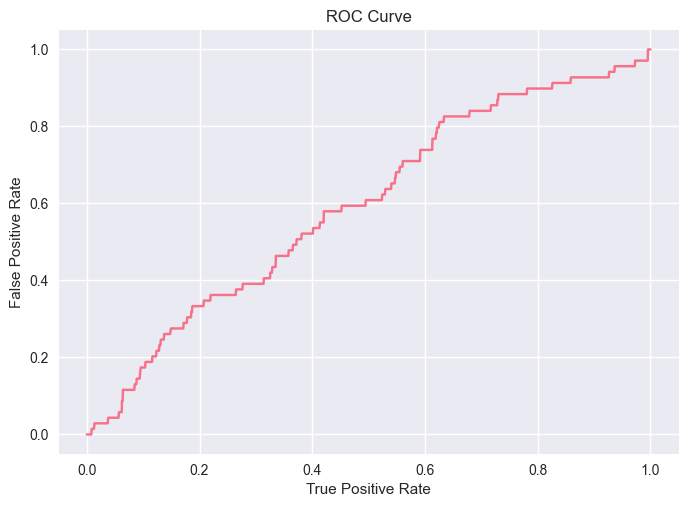

Training set areaUnderROC: 0.596007325636693


In [37]:
# ROC del primero modelo sin hiperparametros
lr_stage = lr_model.stages[-1]
trainingSummary = lr_stage.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

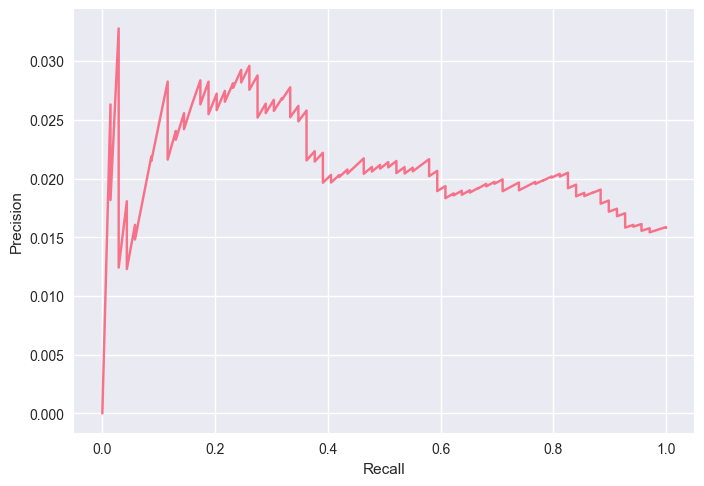

In [38]:
# Imprimiendo la curva entre Precision y Recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### 5.2 Aprendizaje No Supervisado

Para el problema de aprendizaje no supervisado haremos un análisis de clustering: agrupando productos por precio y popularidad

- Segmentación de prodcutos: Identificar productos populares y sus precios
- Objetivo: Marketing personalizado y estrategias diferenciadas
- Enfoque: Clustering basado en patrones de comportamiento


In [39]:
# Agrupa por `product_id` y calcula métricas agregadas:
# - Precio promedio del producto
# - Total de interacciones (vistas, carritos, compras)
# - Número de veces que el producto fue añadido al carrito
# - Número de veces que fue comprado
product_profiles = train_data.groupBy("product_id").agg(
    F.avg("price").alias("avg_price"),
    F.count("*").alias("total_views"),
    F.sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("cart_count"),
    F.sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("purchase_count")
).filter(col("total_views") >= 2)  # Filtra productos con al menos 2 interacciones para reducir el ruido de clientes no frecuentes

# Agrega métricas derivadas de popularidad:
# - popularity_score: puntuación basada en interacción (views + 2*carritos + 5*compras)
# - conversion_rate: tasa de conversión (compras / vistas totales)
product_profiles = product_profiles.withColumn(
    "popularity_score", col("total_views") + col("cart_count") * 2 + col("purchase_count") * 5
).withColumn(
    "conversion_rate", col("purchase_count") / col("total_views")
)

# Cuántos productos se usarán para el clustering y una muestra de ellos
print(f"Productos para clustering: {product_profiles.count():,}")
print("Muestra de perfiles de productos:")
product_profiles.show(10)

# Selecciona las columnas que se usarán como características numéricas para el clustering
clustering_features = ["avg_price", "total_views", "popularity_score"]
print(f"Características seleccionadas: {clustering_features}")

Productos para clustering: 493
Muestra de perfiles de productos:
+----------+------------------+-----------+----------+--------------+----------------+--------------------+
|product_id|         avg_price|total_views|cart_count|purchase_count|popularity_score|     conversion_rate|
+----------+------------------+-----------+----------+--------------+----------------+--------------------+
|   1801766|151.48899999999998|         10|         1|             1|              17|                 0.1|
|  26500139|            167.57|          2|         0|             0|               2|                 0.0|
|   3500046|            398.95|          2|         0|             0|               2|                 0.0|
|   1005116|        1013.79375|          8|         0|             0|               8|                 0.0|
|   4804572|             208.5|          3|         1|             0|               5|                 0.0|
|   1005106|          1482.905|          2|         0|             0|  

In [40]:
# Construye un pipeline de clustering en tres etapas:
# 1. VectorAssembler: combina las columnas numéricas en una sola columna de vectores
# 2. StandardScaler: normaliza los valores numéricos
# 3.KMeans: aplica el algoritmo de agrupamiento con 4 clusters
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
kmeans = KMeans(featuresCol="scaledFeatures", k=4, seed=42)

# Construye el pipeline y lo ajusta (fit) al DataFrame `product_profiles`
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
print("Entrenando modelo K-Means...")
model = pipeline.fit(product_profiles)

# Aplica el modelo de clustering a los perfiles de productos para asignar un clúster a cada producto
clustered_products = model.transform(product_profiles)
print("Modelo completado...")

Entrenando modelo K-Means...
Modelo completado...


In [41]:
print("\n--- Análisis de Clusters ---")

# Estadísticas por cluster
cluster_summary = clustered_products.groupBy("prediction").agg(
    F.count("*").alias("num_products"),
    F.avg("avg_price").alias("avg_price_cluster"),
    F.avg("total_views").alias("avg_popularity"),
    F.avg("conversion_rate").alias("avg_conversion")
).orderBy("prediction")

print("Resumen por cluster:")
cluster_summary.show()


--- Análisis de Clusters ---
Resumen por cluster:
+----------+------------+------------------+------------------+--------------------+
|prediction|num_products| avg_price_cluster|    avg_popularity|      avg_conversion|
+----------+------------+------------------+------------------+--------------------+
|         0|          11| 329.0250898260465|26.636363636363637| 0.05450055017824709|
|         1|         380|208.10833157894743| 2.539473684210526|0.007017543859649122|
|         2|          36|302.35632694953466| 9.305555555555555|0.057147454941572584|
|         3|          66|1038.6167649923605|3.1818181818181817|  0.0202020202020202|
+----------+------------+------------------+------------------+--------------------+



In [42]:
# Se recopilan los resultados agregados de los clústeres desde un DataFrame Spark a una lista local de Python.
cluster_data = cluster_summary.collect()
cluster_results = []


# Se itera sobre cada fila del resumen de clústeres para analizar y clasificar los grupos
for row in cluster_data:
    cluster_id = int(row['prediction'])
    count = int(row['num_products'])
    price = float(row['avg_price_cluster'])
    popularity = float(row['avg_popularity'])
    conversion = float(row['avg_conversion'])
    
    # Clasificación simple
    if price > 500:
        cluster_type = "*** Premium ***"
        description = "Productos caros, baja popularidad, alta conversión"
    elif popularity > 100:
        cluster_type = "*** Populares ***"
        description = "Mucha actividad, precios medios"
    elif conversion > 0.05:
        cluster_type = "*** Best Seller ***"
        description = "Buena conversión, productos exitosos"
    else:
        cluster_type = "***  Basics ***"
        description = "Actividad normal, precios accesibles"

    cluster_results.append({
        'cluster_id': cluster_id,
        'cluster_type': cluster_type,
        'count': count,
        'avg_price': price,
        'avg_popularity': popularity,
        'avg_conversion': conversion,
        'description': description
    })
    
    print(f"\nCluster {cluster_id}: {cluster_type}")
    print(f"  • Productos: {count:,}")
    print(f"  • Precio promedio: ${price:.2f}")
    print(f"  • Popularidad: {popularity:.1f} views")
    print(f"  • Conversión: {conversion:.3f} ({conversion*100:.1f}%)")
    print(f"  • {description}")


Cluster 0: *** Best Seller ***
  • Productos: 11
  • Precio promedio: $329.03
  • Popularidad: 26.6 views
  • Conversión: 0.055 (5.5%)
  • Buena conversión, productos exitosos

Cluster 1: ***  Basics ***
  • Productos: 380
  • Precio promedio: $208.11
  • Popularidad: 2.5 views
  • Conversión: 0.007 (0.7%)
  • Actividad normal, precios accesibles

Cluster 2: *** Best Seller ***
  • Productos: 36
  • Precio promedio: $302.36
  • Popularidad: 9.3 views
  • Conversión: 0.057 (5.7%)
  • Buena conversión, productos exitosos

Cluster 3: *** Premium ***
  • Productos: 66
  • Precio promedio: $1038.62
  • Popularidad: 3.2 views
  • Conversión: 0.020 (2.0%)
  • Productos caros, baja popularidad, alta conversión


In [43]:
# Convertir a DataFrame
df_clusters = pd.DataFrame(cluster_results)

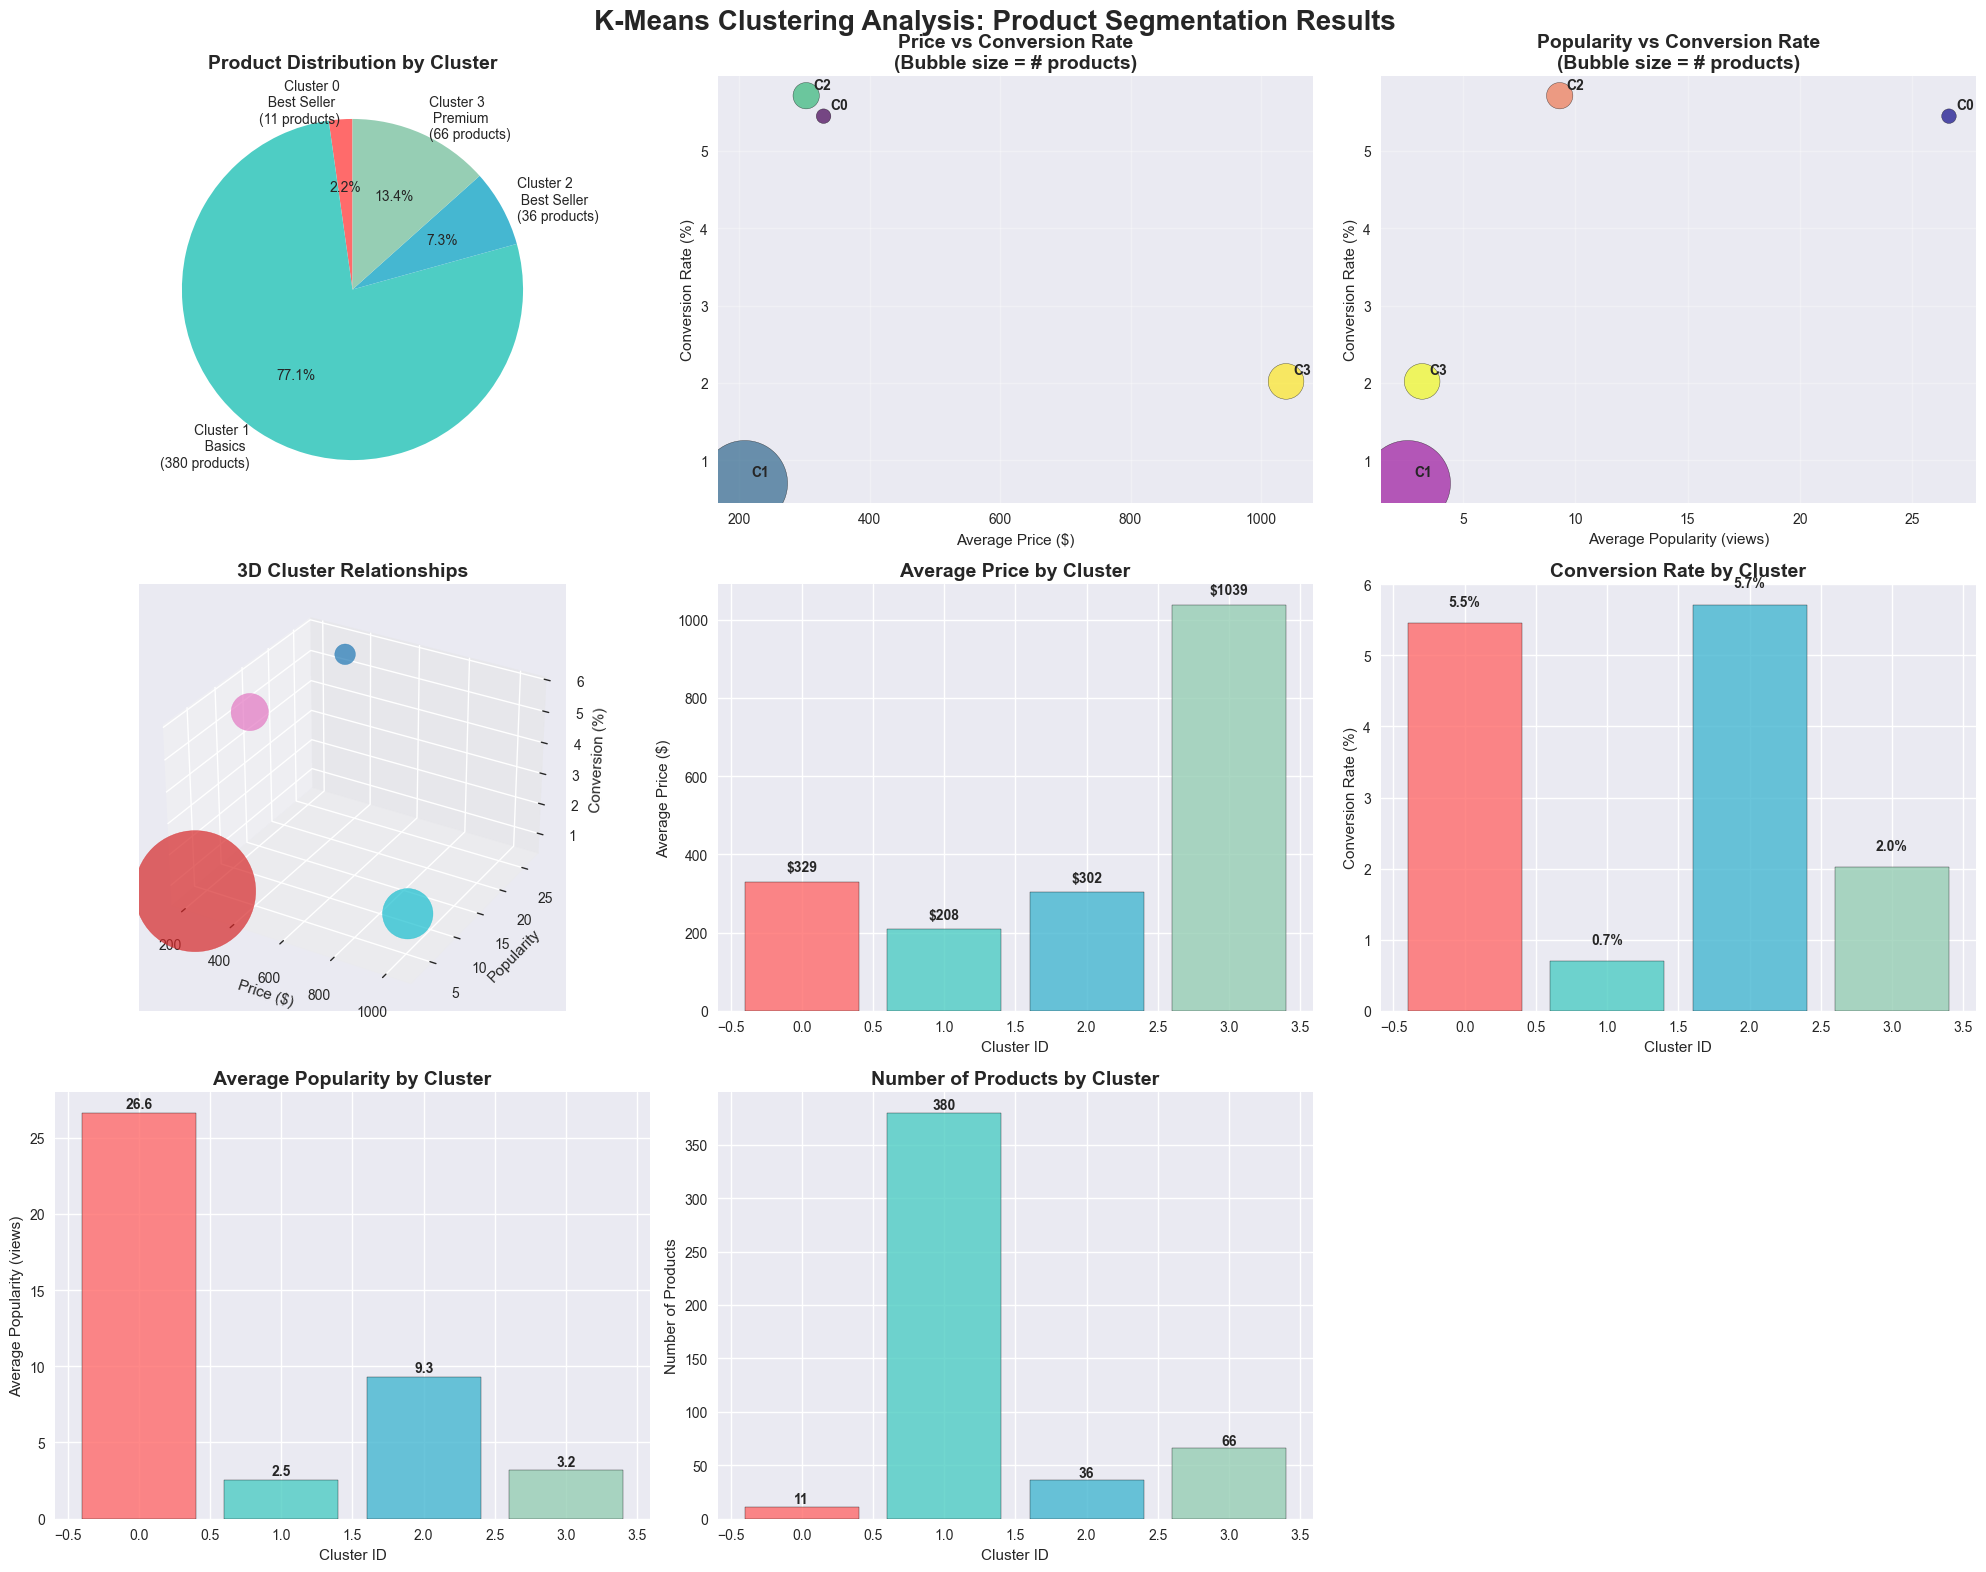

In [44]:
# Clean cluster types for visualization
df_clusters['cluster_label'] = df_clusters['cluster_type'].str.replace('***', '')
df_clusters['conversion_pct'] = df_clusters['avg_conversion'] * 100

# Color palette for clusters
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_colors = dict(zip(df_clusters['cluster_id'], colors))

# Set up el plot
fig = plt.figure(figsize=(20, 16))
fig.suptitle('K-Means Clustering Analysis: Product Segmentation Results', fontsize=20, fontweight='bold', y=0.98)

# Pie chart
plt.subplot(3, 3, 1)
sizes = df_clusters['count']
labels = [f"Cluster {row['cluster_id']}\n{row['cluster_label']}\n({row['count']} products)" 
          for _, row in df_clusters.iterrows()]
colors_pie = [colors[i] for i in range(len(df_clusters))]

plt.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
plt.title('Product Distribution by Cluster', fontsize=14, fontweight='bold')

# Scatter plot de los cluster por precio
plt.subplot(3, 3, 2)
scatter = plt.scatter(df_clusters['avg_price'], df_clusters['conversion_pct'], 
                     s=df_clusters['count']*10, # Size represents number of products
                     c=df_clusters['cluster_id'], cmap='viridis', alpha=0.7, edgecolors='black')

plt.xlabel('Average Price ($)')
plt.ylabel('Conversion Rate (%)')
plt.title('Price vs Conversion Rate\n(Bubble size = # products)', fontsize=14, fontweight='bold')

# Add cluster labels
for _, row in df_clusters.iterrows():
    plt.annotate(f"C{row['cluster_id']}", 
                (row['avg_price'], row['conversion_pct']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.grid(True, alpha=0.3)

# Scatter plot de popularidad
plt.subplot(3, 3, 3)
scatter2 = plt.scatter(df_clusters['avg_popularity'], df_clusters['conversion_pct'],
                      s=df_clusters['count']*10,
                      c=df_clusters['cluster_id'], cmap='plasma', alpha=0.7, edgecolors='black')

plt.xlabel('Average Popularity (views)')
plt.ylabel('Conversion Rate (%)')
plt.title('Popularity vs Conversion Rate\n(Bubble size = # products)', fontsize=14, fontweight='bold')

# Add cluster labels
for _, row in df_clusters.iterrows():
    plt.annotate(f"C{row['cluster_id']}", 
                (row['avg_popularity'], row['conversion_pct']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.grid(True, alpha=0.3)

# Usar visualización 3D de relaciones de clusters
ax_3d = plt.subplot(3, 3, 4, projection='3d')
ax_3d.scatter(df_clusters['avg_price'], df_clusters['avg_popularity'], df_clusters['conversion_pct'],
              s=df_clusters['count']*20, c=df_clusters['cluster_id'], cmap='tab10', alpha=0.7)

ax_3d.set_xlabel('Price ($)')
ax_3d.set_ylabel('Popularity')
ax_3d.set_zlabel('Conversion (%)')
ax_3d.set_title('3D Cluster Relationships', fontsize=14, fontweight='bold')

#Precio promedio por cluster
plt.subplot(3, 3, 5)
bars1 = plt.bar(df_clusters['cluster_id'], df_clusters['avg_price'], 
               color=[colors[i] for i in df_clusters['cluster_id']], alpha=0.8, edgecolor='black')
plt.title('Average Price by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Average Price ($)')

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'${height:.0f}', ha='center', va='bottom', fontweight='bold')

# Conversion rate por cluster
plt.subplot(3, 3, 6)
bars2 = plt.bar(df_clusters['cluster_id'], df_clusters['conversion_pct'],
               color=[colors[i] for i in df_clusters['cluster_id']], alpha=0.8, edgecolor='black')
plt.title('Conversion Rate by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Conversion Rate (%)')

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')


# Popularidad por cluster
plt.subplot(3, 3, 7)
bars3 = plt.bar(df_clusters['cluster_id'], df_clusters['avg_popularity'],
               color=[colors[i] for i in df_clusters['cluster_id']], alpha=0.8, edgecolor='black')
plt.title('Average Popularity by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Average Popularity (views)')

# Add value labels on bars
for i, bar in enumerate(bars3):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')


# Product count por cluster
plt.subplot(3, 3, 8)
bars4 = plt.bar(df_clusters['cluster_id'], df_clusters['count'],
               color=[colors[i] for i in df_clusters['cluster_id']], alpha=0.8, edgecolor='black')
plt.title('Number of Products by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Products')

# Add value labels on bars
for i, bar in enumerate(bars4):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [45]:
print("**** Análisis de Cluster ****")

print(f"{'Cluster':<8} {'Type':<15} {'Products':<10} {'Avg Price':<12} {'Popularity':<12} {'Conversion':<12}")
print("-" * 80)

total_products = df_clusters['count'].sum()
for _, row in df_clusters.iterrows():
    cluster_share = (row['count'] / total_products) * 100
    print(f"{row['cluster_id']:<8} {row['cluster_label']:<15} {row['count']:<10} "
          f"${row['avg_price']:<11.2f} {row['avg_popularity']:<12.1f} {row['conversion_pct']:<11.1f}%")

print(f"\nTotal products analyzed: {total_products}")

**** Análisis de Cluster ****
Cluster  Type            Products   Avg Price    Popularity   Conversion  
--------------------------------------------------------------------------------
0         Best Seller    11         $329.03      26.6         5.5        %
1          Basics        380        $208.11      2.5          0.7        %
2         Best Seller    36         $302.36      9.3          5.7        %
3         Premium        66         $1038.62     3.2          2.0        %

Total products analyzed: 493


In [61]:
#Insights del modelo
best_conversion = df_clusters.loc[df_clusters['avg_conversion'].idxmax()]
highest_price = df_clusters.loc[df_clusters['avg_price'].idxmax()]
most_popular = df_clusters.loc[df_clusters['avg_popularity'].idxmax()]
largest_segment = df_clusters.loc[df_clusters['count'].idxmax()]

print(f"Insights:")
print(f"   • Best Conversion: Cluster {best_conversion['cluster_id']} ({best_conversion['cluster_label']}) - {best_conversion['conversion_pct']:.1f}%")
print(f"   • Highest Price: Cluster {highest_price['cluster_id']} ({highest_price['cluster_label']}) - ${highest_price['avg_price']:.2f}")
print(f"   • Most Popular: Cluster {most_popular['cluster_id']} ({most_popular['cluster_label']}) - {most_popular['avg_popularity']:.1f} views")
print(f"   • Largest Segment: Cluster {largest_segment['cluster_id']} ({largest_segment['cluster_label']}) - {largest_segment['count']} products")

print(f"\nRecomendaciones:")
# Los valores minimos fueron obetnidos de enteder la conversion rate de la tabla anterior donde se observar de 0.7-5% approx
if best_conversion['avg_conversion'] > 0.05:
    print(f"   • Enfoque en escalar y mejorar {best_conversion['cluster_label']} estrategia -> highest conversion rate")
if highest_price['avg_conversion'] < 0.03:
    print(f"   • Investigar {highest_price['cluster_label']} estrategia -> high price pero casi no hay conversions")
if largest_segment['avg_conversion'] < 0.01:
    print(f"   • Optimizar {largest_segment['cluster_label']} - el segmento más grande pero pocas conversions")

# Identify optimization opportunities
zero_conversion_clusters = df_clusters[df_clusters['avg_conversion'] == 0]
if len(zero_conversion_clusters) > 0:
    print(f"   • Poner atención a los zero-conversion clusters: {', '.join(map(str, zero_conversion_clusters['cluster_id'].tolist()))}")

print(f"\n Separar productos por clusters:")
for _, cluster in df_clusters.iterrows():
    portfolio_share = (cluster['count'] / total_products) * 100
    revenue_potential = cluster['avg_price'] * cluster['count'] * cluster['avg_conversion']
    print(f"   • Cluster{cluster['cluster_label']}: {portfolio_share:.1f}% of portfolio, Revenue potential: ${revenue_potential:.2f}")



Insights:
   • Best Conversion: Cluster 2 ( Best Seller ) - 5.7%
   • Highest Price: Cluster 3 ( Premium ) - $1038.62
   • Most Popular: Cluster 0 ( Best Seller ) - 26.6 views
   • Largest Segment: Cluster 1 (  Basics ) - 380 products

Recomendaciones:
   • Enfoque en escalar y mejorar  Best Seller  estrategia -> highest conversion rate
   • Investigar  Premium  estrategia -> high price pero casi no hay conversions
   • Optimizar   Basics  - el segmento más grande pero pocas conversions

 Separar productos por clusters:
   • Cluster Best Seller : 2.2% of portfolio, Revenue potential: $197.25
   • Cluster  Basics : 77.1% of portfolio, Revenue potential: $554.96
   • Cluster Best Seller : 7.3% of portfolio, Revenue potential: $622.04
   • Cluster Premium : 13.4% of portfolio, Revenue potential: $1384.82


In [62]:
# Guardar los modelos
base_path = "/Users/pauescalante/Documents/Maestria/Trimestre 7/BigData/big-data-act/Models/Final/"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

lr_model_path = f"{base_path}/logistic_regression_model_{timestamp}"
try:
    lr_model.write().overwrite().save(lr_model_path)
    print(f"Modelo LR guardado en: {lr_model_path}")
except Exception as e:
    print(f"Error guardando LR: {e}")

# Guardar modelo K-Means completo
kmeans_model_path = f"{base_path}/kmeans_model_{timestamp}"
try:
    # Asumiendo que 'model' es tu pipeline de clustering
    model.write().overwrite().save(kmeans_model_path)
    print(f"Modelo K-Means guardado en: {kmeans_model_path}")
except Exception as e:
    print(f"Error guardando K-Means: {e}")

Modelo LR guardado en: /Users/pauescalante/Documents/Maestria/Trimestre 7/BigData/big-data-act/Models/Final//logistic_regression_model_20250622_133031
Modelo K-Means guardado en: /Users/pauescalante/Documents/Maestria/Trimestre 7/BigData/big-data-act/Models/Final//kmeans_model_20250622_133031


### **6. Conclusión**



En este proyecto final se exploraron técnicas de aprendizaje supervisado y no supervisado utilizando PySpark sobre un conjunto de datos reales de comportamiento en e-commerce. Anteriormente se hace una exploración y limpieza de los datos y a partir de variables de categorización se crean submúestras que representan a la población para reducir el tiempo de computo en millones de registros.

En el caso de aprendizaje supervisado, se entrenó un modelo de regresión logística para predecir la probabilidad de compra, enfrentando el reto de una distribución altamente desbalanceada. Para el aprendizaje no supervisado, se aplicó K-Means para segmentar productos en clústeres basados en métricas de precio, popularidad y conversión. Esta segmentación permite identificar oportunidades estratégicas para acciones de marketing y posicionamiento de productos. El uso de pipelines y transformaciones escalables con PySpark permitió construir un flujo de trabajo eficiente y reproducible para el análisis de grandes volúmenes de datos.

Una conclusión más detallada se comparte en la entrega adicional en formato PDF.